# Data generation
## 1. Model for multiple preferences with individual parties
Consistent with the output in multi_preferences model in `multi_preferences.mod`

In [123]:
import numpy as np
import pandas as pd

In [124]:
# number parameters
n_rooms = 587
n_groups = n_rooms
preference_points = 100
n_preferences = 5
max_range = 20

ROOMS = list(range(1, n_rooms + 1))
PEOPLE = list(range(1, n_groups + 1))
PREFERENCES = list(range(1, n_preferences + 1))

# preference and weight parameters
weights = np.flip(np.sort(np.random.random((n_groups, n_preferences)), axis=1), axis=1)
weights = (weights.T / weights.sum(axis=1)*100).T

preferences = np.random.randint(low=1,high=n_rooms,size=(n_groups, n_preferences))
preferences_lower = preferences
preferences_upper = np.minimum(preferences + np.random.randint(0, 2, (n_rooms, n_preferences)), n_rooms*np.ones((n_rooms, n_preferences))).astype(np.int64)

# save these to text to be interpreted by the models
c = ['PEOPLE', 'PREFERENCES', 'preference_lower', 'preference_upper', 'weights']
table = np.zeros((n_groups*n_preferences, 4), dtype=np.int32)
for i in range(n_groups ):
    for j in range(n_preferences):
        table[i*n_preferences + j][0] = i + 1
        table[i*n_preferences + j][1] = j + 1
        table[i*n_preferences + j][2] = preferences_lower[i,j]
        table[i*n_preferences + j][3] = preferences_upper[i,j]

table = pd.DataFrame({'PEOPLE':table[:,0], 'PREFERENCES':table[:,1], 'preference_lower':table[:,2], 'preference_upper':table[:,3], 'weights':weights.flatten()}).set_index(['PEOPLE', 'PREFERENCES'])

# Populate database
We run this to populate the database with static HMC dorm info. Note that we'll commit this and maintain it as immutable data in the repo--no need to run this again.

In [125]:
import sqlite3 as sql
import csv, os, random

In [126]:
# Populate rooms table
db_path = 'dorms.db'
n_students = 908
if os.path.exists(db_path):
    os.remove(db_path)
db = sql.connect(db_path)
db.executescript(open('../res/up.sql', 'r').read())

dorms = csv.DictReader(open('../res/dorms.csv','r'),
['local_id', 'dorm_id', 'global_id', 'capacity', 'dsa', 'suite'])
dorms.__next__()

for e in dorms:
    local_id = e['local_id']
    dorm_id = int(e['dorm_id'])
    global_id = int(e['global_id'])
    capacity = int(e['capacity'])
    if e['dsa'] == 'TRUE':
        dsa  = 1
    else:
        dsa = 0
    suite = int(e['suite'])
    db.execute(f'INSERT INTO rooms(local_id, dorm_id, global_id, capacity, dsa, suite) VALUES(\'{local_id}\', {dorm_id}, {global_id}, {capacity}, {dsa}, {suite})')

for i in range(n_students):
    id = i + 1
    name = f'Student {id}'
    year = 4 - int(i / n_students*4)
    db.execute(f'INSERT INTO students(id, name, year) VALUES({id}, \'{name}\', {year})')
db.commit()

# make group assignments

size_counts = dict(db.execute('SELECT capacity, COUNT(*) FROM rooms WHERE dsa = 0 GROUP BY capacity;').fetchall())
student_ids = [i[0] for i in db.execute('SELECT id FROM students;').fetchall()]
random.shuffle(student_ids)

group = 1
id = 0
group_rows = []
for s,c in size_counts.items():
    for _ in range(c):
        ids = student_ids[id:id+s]
        group_rows += [(group, a) for a in ids]
        group +=1
        id += s
db.executemany('UPDATE students SET group_id = ? WHERE id = ?;', group_rows)
db.commit()

# populate preferences
db.executemany('INSERT INTO preferences(group_id, preference_id, preference_lower, preference_upper, weight) VALUES(?, ?, ?, ?, ?)', table.reset_index().values.tolist())
db.commit()
db.close()

## Simulate Greedy Room Draw
Assume that all agents act independently, selecting the first available room of highest choice

In [127]:
assignment = np.zeros(n_groups, dtype=np.int32)
weight = np.zeros(n_groups, dtype=np.int32)
for person in range(n_groups):
    assigned = False
    for pref in range(n_preferences):
        for i in range(preferences_lower[person, pref]-1, preferences_upper[person, pref]):
            if not assignment[i]:
                assigned = True
                assignment[i] = person
                weight[i] = n_preferences - pref
                break
        if assigned:
            break
    if not assigned:
        for i in range(n_rooms):
            if not assignment[i]:
                assignment[i] = person
                break
greedy_assignment = pd.DataFrame(assignment, columns=['room number'])
greedy_satisfied = pd.DataFrame(weight, columns=['satisfied'])
greedy_assignment['groups'] = PEOPLE
greedy_satisfied['groups'] = PEOPLE
greedy_assignment.set_index('groups', inplace=True)
greedy_satisfied.set_index('groups', inplace=True)

# transform to get satisfied preference numbers
greedy_satisfied['satisfied'] = greedy_satisfied['satisfied'].apply(lambda x: -x + 6 if x else 0)
greedy_utility = sum(weight)

# AMPL Python API Tests
### Pull from database

In [128]:
from amplpy import AMPL, Environment
import sqlite3 as sql

In [129]:

db = sql.connect(db_path)
n_groups = n_rooms = db.execute('SELECT COUNT(global_id) FROM rooms;').fetchone()[0]
n_preferences = db.execute('SELECT COUNT(DISTINCT preference_id) FROM preferences;').fetchone()[0]
table = pd.DataFrame(data=db.execute('SELECT * FROM preferences;').fetchall(), columns=['PREFERENCES', 'PEOPLE', 'preference_lower', 'preference_upper', 'weights']).set_index(['PEOPLE', 'PREFERENCES'])
db.close()

### Load model and run optimization

In [130]:
# init ampl
ampl_dir = '/usr/bin'
ampl = AMPL(Environment(ampl_dir))
model = 'range_preferences.mod'

In [131]:
# read in model
ampl.eval('option solver gurobi;')
ampl.eval('''option gurobi_options 'outlev 1';''')
ampl.read(filename=model)

In [132]:
# set data
ampl.get_parameter("n_people").set(n_groups)
ampl.get_parameter("n_rooms").set(n_rooms)
ampl.get_parameter("n_preferences").set(n_preferences)
ampl.set_data(data=table, set_name='LINKS')

In [133]:
ampl.solve()

Gurobi 9.5.1: outlev 1
Set parameter OutputFlag to value 1
Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4109 rows, 348091 columns and 697058 nonzeros
Model fingerprint: 0xe2c75f69
Variable types: 0 continuous, 348091 integer (347504 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [4e-03, 8e+01]
  Bounds range     [1e+00, 6e+02]
  RHS range        [1e+00, 1e+00]
Presolve removed 1911 rows and 2935 columns
Presolve time: 3.88s
Presolved: 2198 rows, 345156 columns, 695915 nonzeros
Variable types: 0 continuous, 345156 integer (344569 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2831740e+04   5.713384e+04   0.000000e+00      7s
    2140    1.9967143e+04   0.000000e+00   0.000000e+00      8s

Root relaxation: objective 1.996714e+04, 2140 iterations,

In [134]:
optim_assignments = ampl.get_variable('room_number').get_values().to_pandas()
# clean up the dataframe
optim_assignments = optim_assignments.rename(columns={'room_number.val': 'room number'}).set_axis(np.arange(1, n_rooms + 1, 1, dtype=int)).rename_axis('Groups').astype(int)
optim_utility = int(ampl.get_objective('Objective').value())


In [135]:
# process output
optim_satisfied = ampl.get_variable('satisfied').get_values().to_pandas()
optim_satisfied['group'] = [int(a[0]) for a in optim_satisfied.index]
optim_satisfied['preference'] = [int(a[1]) for a in optim_satisfied.index]
optim_satisfied.set_index(['group', 'preference'],inplace=True)
optim_satisfied.rename(columns={'satisfied.val':'satisfied'}, inplace=True)
optim_satisfied = optim_satisfied.astype(bool)

def arg(x):
    for j in x.index:
        if x.loc[j]['satisfied']:
            return j[1]
    return 0


        
optim_satisfied = optim_satisfied.groupby('group').apply(arg).to_frame(name='satisfied')

In [ ]:
# write assignments


# Comparison of Greedy and Optimized Assignments

In [136]:
import matplotlib.pyplot as plt

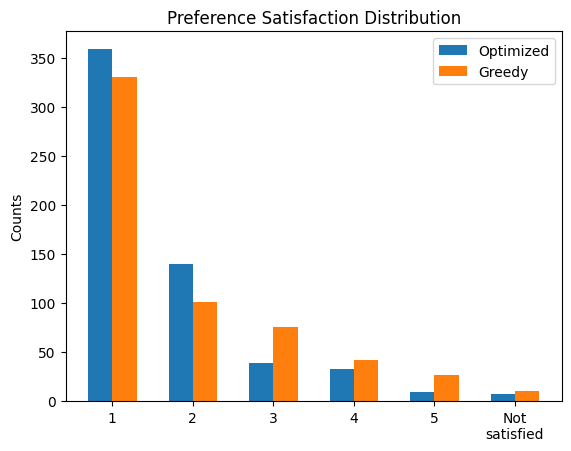

##### METRICS ######
Total utility greedy: 2249
Total utility optimized: 18906

Percentage improvement in optimized model: 740.64%
Percentage improvement any preference satisfaction: 13.50%

Percentage improvement pref 1 satisfaction: 8.46%
Percentage improvement pref 2 satisfaction: 38.61%
Percentage improvement pref 3 satisfaction: -7.14%*


*Note: preference rank satisfactions are codependent. This means that a negative improvement for one preference doesn't imply an overall worse preference satisfaction performance


In [217]:
labels = [str(a) for a in range(1, n_preferences + 1)] + ['Not\nsatisfied']
index = np.arange(n_preferences + 1) 
x = np.arange(0, n_preferences + 1)
optim_y = [optim_satisfied.satisfied.value_counts().values[i] for i in range(n_preferences + 1)]
greedy_y = [greedy_satisfied.satisfied.value_counts().values[i] for i in range(n_preferences + 1)]
width = 0.3

plt.bar(x, optim_y, width, label='Optimized')
plt.bar(x + width, greedy_y, width, label='Greedy')
plt.title('Preference Satisfaction Distribution')
plt.ylabel('Counts')
plt.xticks(x + width / 2, labels)
plt.legend()
plt.show()

print(f'''##### METRICS ######
Total utility greedy: {greedy_utility}
Total utility optimized: {optim_utility}

Percentage improvement in optimized model: {100*(optim_utility/greedy_utility - 1):.2f}%
Percentage improvement any preference satisfaction: {100*(sum((optim_satisfied > 0).satisfied)/sum((greedy_satisfied > 0).satisfied) - 1):.2f}%

Percentage improvement pref 1 satisfaction: {100*(sum((optim_satisfied == 1).satisfied)/sum((greedy_satisfied == 1).satisfied) - 1):.2f}%
Percentage improvement pref 2 satisfaction: {100*(sum((optim_satisfied == 2).satisfied)/sum((greedy_satisfied == 2).satisfied) - 1):.2f}%
Percentage improvement pref 3 satisfaction: {100*(sum((optim_satisfied == 3).satisfied)/sum((greedy_satisfied == 3).satisfied) - 1):.2f}%*


*Note: preference rank satisfactions are codependent. This means that a negative improvement for one preference doesn't imply an overall worse preference satisfaction performance''')

1    359
2    140
3     39
4     33
5      9
0      7
Name: satisfied, dtype: int64